# Text Classification

Using emotion dataset to train sentiment analysis transformer

## Load Emotion Dataset

In [2]:
%pip install datasets # Hugging Face Datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
emotions_dataset = load_dataset("emotion")

emotions_dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions_dataset["train"]
validation_ds = emotions_dataset["validation"]
test_ds = emotions_dataset["test"]

## Understand Data

In [6]:
emotions_dataset.set_format("pandas") # Does not change underlying format
df = emotions_dataset["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
# Add string label for understanding (model won't use)

def add_string_labels(batch):
    return emotions_dataset["train"].features["label"].int2str(batch)

df["label_name"] = df["label"].apply(add_string_labels)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Visualize Data

Text(0.5, 1.0, 'Label Frequency')

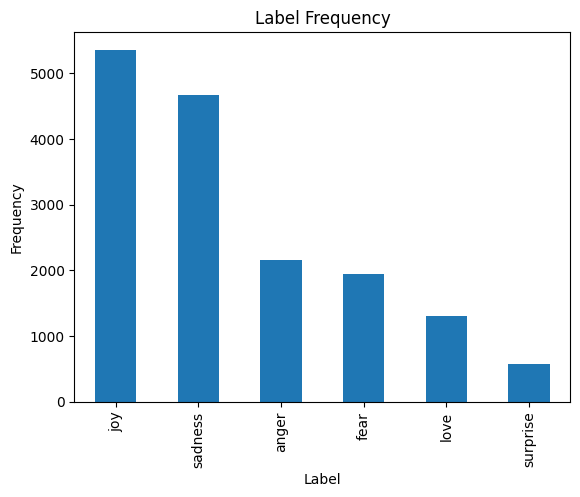

In [8]:
df['label_name'].value_counts(ascending=False).plot.bar() # In descending order
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Frequency')

# Joy and sadness apear way more than love and surprise

### Check Token Length

Text(0.5, 0.98, '')

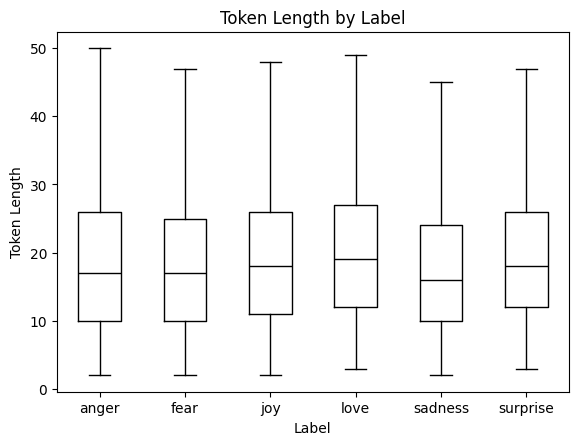

In [9]:
df['length'] = df['text'].apply(lambda x: len(x.split()))

# Plot length by label

df.boxplot('length', by='label_name', grid=False, showfliers=False, color='black')
plt.xlabel('Label')
plt.ylabel('Token Length')
plt.title('Token Length by Label')
plt.suptitle('') # Remove super title (otherwise will be boxplot grouped by label name)

### Reset Dataset Format

In [10]:
emotions_dataset.reset_format()

## Aside: Subword Tokenization

Tokenizing characters increases training time, because the model has to build up letters to learn the relationships between different words.

Whole word tokenization is not efficient, because it does not properly account for punctuation. For example, "Hello" and "Hello!" would be considered different tokens, even though they have similar meanings. The best tokenization for "Hello!" is "Hello", "!", which is essentially what subword tokenization does.

In [12]:
# Example of subword tokenization

from transformers import AutoTokenizer # Load tokenizer associated w/ pretrained model

distil_bert_model = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(distil_bert_model)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
encoded = tokenizer("Hello, how are you?")

print(encoded)

print(tokenizer.convert_ids_to_tokens(encoded['input_ids'])) # CLS is for start of sequence, SEP is for end of sequence

print(tokenizer.decode(encoded['input_ids']))

{'input_ids': [101, 7592, 1010, 2129, 2024, 2017, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'hello', ',', 'how', 'are', 'you', '?', '[SEP]']
[CLS] hello, how are you? [SEP]


## Tokenizing Emotions Dataset

In [14]:
# Tokenize batch of data

def tokenize_data(batch):
    return tokenizer(batch["text"], padding=True, truncation=True) # Pad to longest size in batch and truncate to max content size of model

encoded_emotions = emotions_dataset.map(tokenize_data, batched=True, batch_size=None) # Entire dataset as 1 batch

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Training Classifier

### Feature Extraction

Don't modify pretrained model

In [15]:
from transformers import AutoModel

distil_bert_model = "distilbert-base-uncased"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Use CPU if available

model = AutoModel.from_pretrained(distil_bert_model).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

#### Extract Hidden States

In [16]:
def extract_hidden_states(batch):
    # Values on GPU if available
    inputs = {key: value.to(device) for key, value in batch.items() if key in tokenizer.model_input_names}

    # Get hidden states
    with torch.no_grad(): # Disable gradient descent
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [17]:
encoded_emotions.set_format("torch", columns=["input_ids", "attention_mask", "label"]) # Convert input to tensors

emotion_hidden_states = encoded_emotions.map(extract_hidden_states, batched=True) # Super slow on CPU

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

#### Train model

In [18]:
x_train = np.array(emotion_hidden_states["train"]["hidden_state"])
y_train = np.array(emotion_hidden_states["train"]["label"])

x_validation = np.array(emotion_hidden_states["validation"]["hidden_state"])
y_validation = np.array(emotion_hidden_states["validation"]["label"])

x_test = np.array(emotion_hidden_states["test"]["hidden_state"])
y_test = np.array(emotion_hidden_states["test"]["label"])

x_train.shape, x_validation.shape, x_test.shape


# Do logistic regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=3000) # High number to improve results (logistic regression is inexpensive anyways)
lr_model.fit(x_train, y_train) # Hidden state is input to model, label is prediction

lr_model.score(x_validation, y_validation) # See accuracy of model

0.635

### Fine-tuning

Update weights of pretrained model based on new (emotions) dataset

In [19]:
# Get base model (ignore weight initalization warning)

from transformers import AutoModelForSequenceClassification

num_labels = 6

model = AutoModelForSequenceClassification.from_pretrained(distil_bert_model, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Define accuracy metrics

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [26]:
# Set hyper-parameters

from transformers import TrainingArguments

batch_size = 64
logging_steps = len(encoded_emotions["train"]) // batch_size
model_name = "./distilbert_emotion_finetuned"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch", # Save model at each epoch
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level = "error",
                                  report_to="none", # Disable WandB logging
                                  load_best_model_at_end=True,
                                  )

#### Train Model

In [27]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_emotions["train"],
                  eval_dataset=encoded_emotions["validation"],
                  tokenizer=tokenizer,
                  )

trainer.train()

<ipython-input-27-6e2cce75e451>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.814700,0.309099,0.907000,0.906067
2,0.250600,0.218318,0.925500,0.925228


TrainOutput(global_step=500, training_loss=0.5326529159545899, metrics={'train_runtime': 278.6826, 'train_samples_per_second': 114.826, 'train_steps_per_second': 1.794, 'total_flos': 720342861696000.0, 'train_loss': 0.5326529159545899, 'epoch': 2.0})